# Experiment 3

The goal of this experiment was implement a simple reference game between a sender and a receiver with overcomplete vocabulary using a fully-differentiable autoencoder. I was interested whether discrete alphabet could emerge only by imposing L1 regularization. This setting is known as sparse autoencoder.

In [58]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.optim import Adam
import seaborn as sns; sns.set()

torch.manual_seed(1773)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, alphabet_size):
        super(SparseAutoencoder, self).__init__()
        self.sender = nn.Embedding(input_size, alphabet_size)
        self.receiver = nn.Linear(alphabet_size, output_size)

    def forward(self, x):
        encoded = self.sender(x)
        decoded = F.softmax(self.receiver(encoded))
        return encoded, decoded

In [4]:
class DifferentiableWorld:
    def __init__(self, batch_size, world_size):
        self.batch_size, self.world_size = batch_size, world_size
        self.reset()
    
    def reset(self):
        self.hidden_state = torch.randint(
            high=self.world_size, 
            size=(self.batch_size,),
            dtype=torch.long
        )
    
    def receive_observation(self):
        return self.hidden_state
    
    def evaluate_prediction(self, pred):
        return F.nll_loss(pred, self.hidden_state)

In [5]:
class Sender:
    
    def __init__(self, input_size, alphabet_size, learning_rate):
        self.policy = SenderPolicyNet(input_size=input_size, alphabet_size=alphabet_size)
        self.optimizer = Adam(params=self.policy.parameters(), lr=learning_rate, weight_decay=0.000001)
          
    def send_message(self, input):
        probs = self.policy(input)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.last_action_probs, self.last_action = distribution.log_prob(action), action
        return action
    
    def teach(self, rewards):
        self.optimizer.zero_grad()  
        loss = -(self.last_action_probs * rewards).sum()
        loss.backward()
        self.optimizer.step()
        return loss
    
class Receiver:
    
    def __init__(self, alphabet_size, output_size, learning_rate):
        self.policy = ReceiverNet(alphabet_size, output_size)
        self.optimizer = Adam(params=self.policy.parameters(), lr=learning_rate, weight_decay=0.000001)
          
    def predict(self, message):
        self.received_message = message
        return self.policy(message)
    
    def teach(self, loss):
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        return self.policy.linear.weight.grad
    
sender = Sender(10, 25, learning_rate=0.1)
receiver = Receiver(25, 10, learning_rate=0.1)
world = DifferentiableWorld(10, 10)
for epoch in range(10000):
    observation = world.receive_observation()
    message = sender.send_message(observation)
    prediction = receiver.predict(message)
    loss = world.evaluate_prediction(prediction)
    rewards = receiver.teach(loss)
    sender.teach(rewards[message])
    world.reset()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss {loss:.2f}')
        print(observation, message, prediction.argmax(dim=1))

Epoch 0, loss -0.13
tensor([2, 5, 1, 3, 2, 3, 6, 4, 6, 9]) tensor([ 6, 12, 19, 13,  6, 24,  7, 11, 14,  9]) tensor([8, 4, 3, 5, 8, 3, 1, 1, 2, 7])
Epoch 100, loss -0.27
tensor([7, 1, 1, 2, 7, 5, 2, 9, 2, 1]) tensor([13, 19, 10,  8,  1, 12, 11, 22, 23, 13]) tensor([0, 8, 9, 2, 7, 5, 1, 3, 1, 0])
Epoch 200, loss -0.48
tensor([4, 8, 4, 9, 4, 0, 6, 4, 6, 2]) tensor([ 8, 11,  6, 20,  6, 18, 19, 11, 14,  8]) tensor([2, 2, 4, 9, 4, 6, 8, 2, 6, 2])
Epoch 300, loss -0.39
tensor([3, 6, 4, 3, 1, 7, 3, 1, 2, 3]) tensor([24, 14,  5, 16, 23,  8, 15, 11,  0, 16]) tensor([3, 6, 0, 4, 1, 7, 7, 2, 3, 4])
Epoch 400, loss -0.60
tensor([9, 2, 4, 5, 9, 5, 9, 9, 8, 0]) tensor([ 5, 14,  6, 17,  4, 17,  4, 10, 18,  0]) tensor([0, 6, 4, 5, 9, 5, 9, 9, 6, 3])
Epoch 500, loss -0.89
tensor([7, 1, 7, 5, 9, 2, 1, 9, 3, 2]) tensor([ 8, 11,  8, 24, 10, 23, 11,  4, 22, 23]) tensor([7, 1, 7, 3, 9, 2, 1, 9, 3, 2])
Epoch 600, loss -0.46
tensor([4, 5, 3, 5, 4, 0, 6, 3, 8, 5]) tensor([ 2, 17,  0, 24,  8, 18, 14, 11, 20, 10]

In [59]:
def visualize_codebook(agent):
    sns.heatmap(F.softmax(agent.policy.linear.weight, dim=1).detach().numpy(), annot=True, fmt='.1f')

A injective function from world states to alphabet


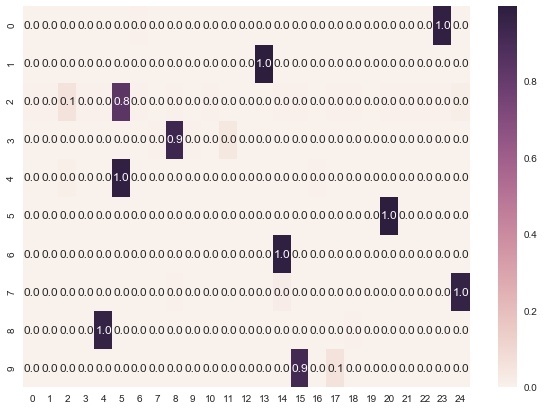

In [60]:
visualize_codebook(sender)
print('A injective function from world states to alphabet')

A surjective function from alphabet to world states


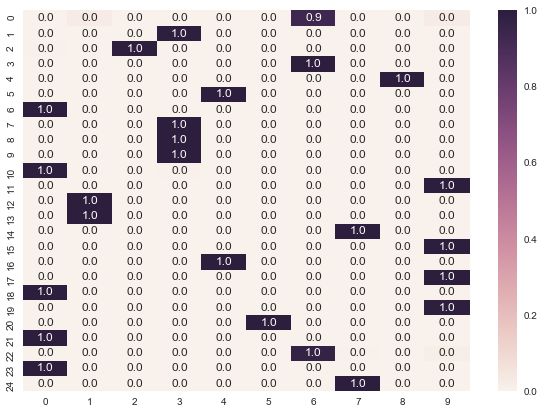

In [61]:
visualize_codebook(receiver)
print('A surjective function from alphabet to world states')

The encoder (sender's codebook) as a function $e$ is the inverse of decoder $d$ (receiver's codebook), i.e. $e = d^{-1}$ and $e \circ d = id$ (modulo the non-linearity). This can be seen by applying Moore-Penrose pseudoinverse to receiver's weights and comapring it to the transpose of receiver's weights.

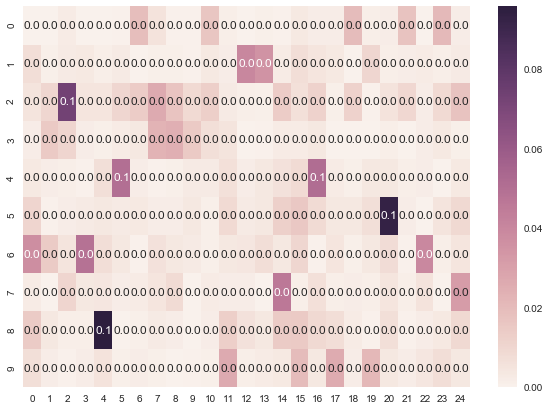

In [62]:
sns.heatmap(torch.abs(receiver.policy.linear.weight.pinverse()).detach().numpy(), annot=True, fmt='.1f')

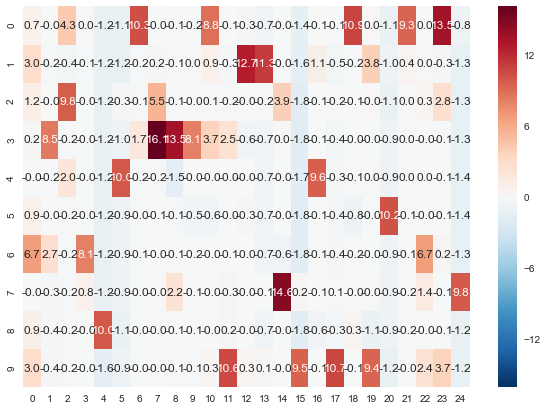

In [64]:
sns.heatmap(receiver.policy.linear.weight.transpose(dim0=0, dim1=1).detach().numpy(), annot=True, fmt='.1f')